## Library used

In [473]:
#utilité générale
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from scipy.stats.mstats import winsorize
from patsy import dmatrices

#utilité CoxPH
from sklearn.model_selection import train_test_split
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

#utilité pour les autres modèles
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


# Data Quality Check

In [474]:
bd = pd.read_excel("D:/Statitics TN/Atelier 2A/SNI.xlsx")

In [475]:
#Voir les année d'observation et le nombre d'entreprise observé
au = bd['Annee'].unique()
print("Année d'observation :", au)

entreprise_obs = bd['numtiers'].unique()
print("nombre d'entreprise observée :", len(entreprise_obs))

Année d'observation : [2015 2016 2017 2019 2018]
nombre d'entreprise observée : 482


In [476]:
#voir les variables catégorielles dans la base
cat = [var for var in bd.columns if bd[var].dtype=='O']

print('Il y a {} variables catégorielles \n'.format(len(cat)))

print('Les variables catégorielles sont :', cat)

Il y a 12 variables catégorielles 

Les variables catégorielles sont : ['EXPERIENCE_MANAGEMENT_MOYENNE_DIRIGEANT', 'DIVERSITE_CLIENTS', 'DIVERSITE_FOURNISSEURS', 'IMPACT_SOCIAUX_ENVIRONNEMENTAL', 'NIVEAU_COMPETITIVITE', 'QUALITE_INFORMATION_FINANCIERE', 'REPUTATION', 'STRUCTUREDUMANAGEMENT', 'SUPPORT', 'POSITIONNEMENTMARCHE', 'Categorie_juridique', 'Secteurs']


In [477]:
#voir les variables numériques dans la base
nm = [var for var in bd.columns if bd[var].dtype!='O']

print('Il y a {} variables numériques \n'.format(len(nm)))

print('Les variables numériques sont :', nm)

Il y a 25 variables numériques 

Les variables numériques sont : ['numtiers', 'Annee', 'defaut', 'CHIFFRE_AFFAIRES', 'EXCEDENT_BRUT_EXPLOITATION', 'RESULTAT_EXPlOITATION', 'RESULTAT_NET', 'FINANCEMENT_PERMANENT', 'FONDS_DE_ROULEMENT', 'BESOIN_FONDS_ROULEMENT', 'CAPITAUX_PROPRES', 'TRESORIE_NETTE', 'TOTAL_BILAN', 'DETTE_FINANCIERE', 'ACTIF_CIRCULANT', 'PASSIF_CIRCULANT', 'TOTAL_ACTIF', 'TOTAL_PASSIF', 'DELAI_REGLEMENT_CLIENTS', 'DELAI_REGLEMENT_FOURNISSEURS', 'AUTO_FINANCEMENT', 'FRAIS_FINANCIERS', 'STOCK', 'Cote en bourse', 'Appartenance a un groupe']


# EDA

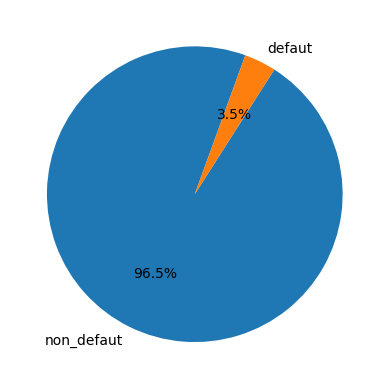

In [478]:
# Calculez le nombre de défauts et de non-défauts
counts = bd['defaut'].value_counts()

# Créez les labels en fonction des valeurs uniques dans 'bd'
labels = ['defaut' if x == 1 else 'non_defaut' for x in counts.index]

# Créez le diagramme circulaire
fig, ax = plt.subplots()
ax.pie(counts, labels=labels, autopct='%1.1f%%', startangle=70)
plt.show()


In [479]:
grouped_data = bd.groupby("Annee")

# Compter le nombre d'entreprises et de défauts pour chaque année
entreprise_counts = grouped_data["numtiers"].nunique()
defaut_counts = grouped_data["defaut"].sum()  # Somme des valeurs binaires (1 pour défaut)

# Créer un DataFrame avec les résultats
resultats = pd.DataFrame({
    "Nombre d'entreprises observées": entreprise_counts,
    "Nombre de défauts observés": defaut_counts
})

resultats

,Nombre d'entreprises observées,Nombre de défauts observés
Annee,,
2015,356,17
2016,371,4
2017,336,6
2018,254,11
2019,204,15


In [480]:
grouped_data_2 = bd.groupby("numtiers")

annees_observations = bd["Annee"].unique()


# Compter le nombre d'années d'observation pour chaque entreprise
annees_observation_par_entreprise = grouped_data_2["Annee"].nunique()

# Filtrer les entreprises observées pendant toutes les années
entreprises_observées_toutes_années = annees_observation_par_entreprise[annees_observation_par_entreprise == len(annees_observations)]

# Afficher les entreprises observées pendant toutes les années
print("Entreprises observées pendant toutes les années d'observation:")
print(len(entreprises_observées_toutes_années))

Entreprises observées pendant toutes les années d'observation:
78


In [481]:
juridic_counts = bd.groupby(['Categorie_juridique', 'defaut']).size().unstack(fill_value=0)

taux_defaut_par_categorie = juridic_counts[1] / (juridic_counts[0] + juridic_counts[1])

pd.DataFrame({"Taux de defaut" : taux_defaut_par_categorie})


,Taux de defaut
Categorie_juridique,
Autres forme juridique,0.000000
SA,0.033088
SARL,0.039627


In [482]:
secteur_counts = bd.groupby(['Secteurs', 'defaut']).size().unstack(fill_value=0)

# Calcul du taux de défaut pour chaque secteur
secteur_counts['Taux_Defaut'] = secteur_counts[1] / (secteur_counts[0] + secteur_counts[1])

df_taux_defaut = secteur_counts[['Taux_Defaut']].reset_index()

# Affichage du DataFrame
df_taux_defaut

defaut,Secteurs,Taux_Defaut
0,Activites financières,0.050000
1,Administrations publiques,0.000000
2,"Agriculture, chasse et sylviculture",0.000000
3,Autres sections,0.069231
4,Bâtiments et travaux publics,0.058140
5,"Commerce, reparations automobiles et d'article...",0.016097
6,Hôtels et restaurants,0.000000
7,Industries agroalimentaires et du tabac,0.015789
8,Industries chimiques et parachimiques,0.025641
9,"Industries du textile, de l'habillement et des...",0.048780


In [483]:
defaut_par_annee = bd.groupby(["Annee", "numtiers"])["defaut"].mean().groupby("Annee").mean()

pd.DataFrame(defaut_par_annee)

,defaut
Annee,
2015,0.047753
2016,0.010782
2017,0.017857
2018,0.043307
2019,0.073529


In [484]:
jr = bd.copy()

In [485]:
# Grouper par 'Secteurs' et vérifier s'il y a des défauts
secteur_defaut = jr.groupby('Secteurs')['defaut'].max()

# Créer la nouvelle colonne 'Secteur_class'
jr['Secteur_class'] = jr['Secteurs'].apply(lambda x: 'Sans défaut' if secteur_defaut[x] == 0 else 'Avec défaut')

In [486]:
jr['Secteur_class'].value_counts()

Secteur_class
Avec défaut    1396
Sans défaut     125
Name: count, dtype: int64

In [487]:
jr['Taille_Entreprise'] = np.log(jr['CHIFFRE_AFFAIRES'])  # log(CA) : taille entreprise

In [488]:
jr['Taille_Entreprise'].head()

0    19.279653
1    19.369968
2    19.125887
3    19.166978
4    18.962932
Name: Taille_Entreprise, dtype: float64

In [489]:
jr['Taille_Entreprise'].max()

24.563724170212907

## Courbe de survie

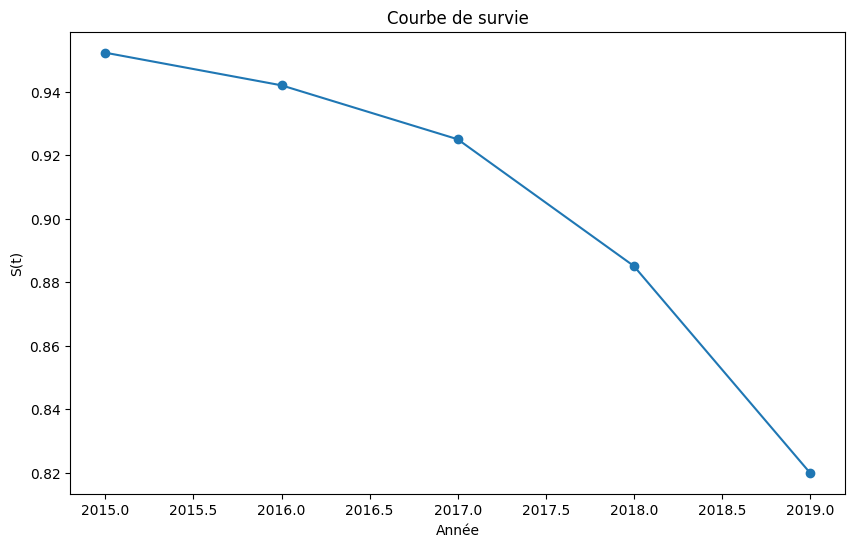

In [490]:
result_data = {
  'Annee': [int(x) for x in [2015, 2016, 2017, 2018, 2019]],
  'defaut': [0, 0, 0, 0, 0],
  0: [339, 367, 330, 243, 189],
  1: [17, 4, 6, 11, 15],
  'n': [356, 371, 336, 254, 204],
  'd': [0.047753, 0.010782, 0.017857, 0.043307, 0.073529],
  's': [0.952247, 0.989218, 0.982143, 0.956693, 0.926471],
  'S': [0.952247, 0.941980, 0.925, 0.8851, 0.82]
}


result = pd.DataFrame(result_data)

plt.figure(figsize=(10, 6))
plt.plot(result['Annee'], result['S'], marker='o')
plt.xlabel('Année')
plt.ylabel('S(t)')
plt.title('Courbe de survie')
plt.grid(False)
plt.show()

# Calcul des Ratios

In [491]:
# traitement pour ACTIF_CIRCULANT et PASSIF_CIRCULANT
sector_means_actif = jr.groupby('Secteurs')['ACTIF_CIRCULANT'].mean()
sector_means_passif = jr.groupby('Secteurs')['PASSIF_CIRCULANT'].mean()

sector_means_dict_actif = sector_means_actif.to_dict()
sector_means_dict_passif = sector_means_passif.to_dict()

jr['ACTIF_CIRCULANT'] = jr.apply(lambda x: sector_means_dict_actif[x['Secteurs']] if x['ACTIF_CIRCULANT'] == 0 else x['ACTIF_CIRCULANT'], axis=1)
jr['PASSIF_CIRCULANT'] = jr.apply(lambda x: sector_means_dict_passif[x['Secteurs']] if x['PASSIF_CIRCULANT'] == 0 else x['PASSIF_CIRCULANT'], axis=1)


# traitement pout TOTAL_ACTIF
sector_means_TA = jr.groupby('Secteurs')['TOTAL_ACTIF'].mean()
sector_means_dict_TA = sector_means_TA.to_dict()
jr['TOTAL_ACTIF'] = jr.apply(lambda x: sector_means_dict_TA[x['Secteurs']] if x['TOTAL_ACTIF'] == 0 else x['TOTAL_ACTIF'], axis=1)

In [492]:
jr['RLG'] = jr['ACTIF_CIRCULANT']/jr['PASSIF_CIRCULANT'] #ratio de liquidité globale
jr['RKP'] = jr['CAPITAUX_PROPRES']/jr['TOTAL_PASSIF'] #ratio des capitaux propres
jr['MBE'] = jr['EXCEDENT_BRUT_EXPLOITATION']/jr['CHIFFRE_AFFAIRES'] #marge brute d'exxploitation
jr['RE'] = jr['RESULTAT_NET']/jr['TOTAL_ACTIF'] #rendement économique
jr['RD'] = 1 - jr['RKP'] #ratio d'endettement
jr['RDA'] = jr['CHIFFRE_AFFAIRES']/jr['TOTAL_ACTIF'] #ratio de rotation des actifs

In [493]:
variables = ['RLG', 'RKP', 'MBE', 'RE','RD','RDA']

# Calcul des statistiques descriptives
descriptive_stats = jr[variables].describe()

descriptive_stats

,RLG,RKP,MBE,RE,RD,RDA
count,1521.000000,1520.000000,1521.000000,1521.000000,1520.000000,1521.000000
mean,2.352496,0.289734,19.487807,0.027990,0.710266,1.207294
std,7.323508,0.228017,757.468159,0.082681,0.228017,1.012293
min,0.007588,-2.990561,-26.270117,-1.276431,0.037428,0.000694
25%,1.233140,0.153674,0.028577,0.006527,0.587916,0.739949
50%,1.702021,0.258154,0.060557,0.019439,0.741846,1.039180
75%,2.313138,0.412084,0.107943,0.049928,0.846326,1.520506
max,247.322767,0.962572,29541.295457,0.857895,3.990561,26.485113


In [494]:
p99 = jr[variables].quantile(0.99)

p99


RLG    12.381110
RKP     0.819309
MBE     0.736786
RE      0.262474
RD      1.182289
RDA     3.915259
Name: 0.99, dtype: float64

# WoE

In [495]:
def calculate_woe(df, col, target_col):
    
    total_pos = df[target_col].sum() #nb total des defaut==1
    total_neg = len(df) - total_pos #nb total des defaut==0
    woe_values = {}
    
    for category in df[col].unique():
        pos = df[(df[col] == category) & (df[target_col] == 1)].shape[0]
        neg = df[(df[col] == category) & (df[target_col] == 0)].shape[0]
        
        # Éviter la division par zéro
        if pos == 0:
            pos_dist = 0.0001
        else:
            pos_dist = pos / total_pos
        
        if neg == 0:
            neg_dist = 0.0001
        else:
            neg_dist = neg / total_neg
        
        # Calcul du WoE
        woe = np.log(pos_dist / neg_dist)
        woe_values[category] = woe
    
    return woe_values


# Features Selection

On se dit qu'on va observer les valeurs du WoE et l'Information Value pour choisir nos variables.

### $\textbf{Observation des ratios}$

##### $\textbf{Winsorization}$

La winsorisation (winsorizing en anglais) est un procédé en statistiques visant à limiter l'impact de données aberrantes dans l'estimation d'un paramètre. Le nom winsorisation a été donné par John Tukey en l'honneur du biostatisticien Charles Winsor.

Dans la fonction winsorize le paramètre $\textbf{limits}$ indique les valeurs à remplacer avec la méthode.

Par exemple : limits = [0.01,0.025] : les valeurs en dessous du 1er percentile seront remplacées par la valeur qui se trouve au 1er percentile et les valeurs qui sont superieures au 97.5eme percentile sont remplacées par la valeur au 97.5eme percentile.

In [496]:
#RE
jr['RE'] = winsorize(jr['RE'], limits=[0.25,0.01])
#Rotation des actifs
jr['RDA'] = winsorize(jr['RDA'], limits = [0.25,0.005])
#ratio d'endettement
jr['RD'] = winsorize(jr['RD'], limits = [0.01,0.025])
#Marge brute d'exploitation
jr['MBE'] = winsorize(jr['MBE'], limits = [0.1,0.0025])
#Ratio de Liquidité générale
jr['RLG'] = winsorize(jr['RLG'], limits = [0.01,0.05])
#ratio des capitaaux propres
jr['RKP'] = winsorize(jr['RKP'], limits = [0.029, 0])

In [497]:
descriptive_stats_win = jr[variables].describe()

descriptive_stats_win

,RLG,RKP,MBE,RE,RD,RDA
count,1521.000000,1520.000000,1521.000000,1521.000000,1521.000000,1521.000000
mean,1.913494,0.298270,0.096490,0.038408,0.702786,1.271792
std,0.972658,0.189170,0.131318,0.047146,0.188192,0.676649
min,0.400001,0.003300,0.004307,0.006527,0.179404,0.739949
25%,1.233140,0.153674,0.028577,0.006527,0.588068,0.739949
50%,1.702021,0.258154,0.060557,0.019439,0.741949,1.039180
75%,2.313138,0.412084,0.107943,0.049928,0.846359,1.520506
max,4.528551,0.962572,1.196619,0.262515,1.008841,4.299541


##### $\textbf{Discrétisation}$

In [498]:
bins = [-np.inf, 0.0194, np.inf]
#La classe 0 contient les individus dont le RE est 1.94% et la classe 1 contient les individus dont le RE est >1.94%
labels = [0,1]
jr['RE_discret'] = pd.cut(jr['RE'], bins = bins, labels=labels)


In [499]:
bins = [-np.inf,0.2580506576081591,np.inf]
#la classe 0 contient les individus dont le RKP est <25.8% et la classe 1 contient les individus dont le RKP est >25.8%
labels = [0,1]
jr['RKP_discret'] = pd.cut(jr['RKP'], bins=bins, labels=labels)

In [500]:
bins = [-np.inf, 1.18, np.inf]
#la classe 0 contient les individus dont le RDA est <1.18% et la classe 1 contient les individus dont le RDA est >1.18%
labels = [0,1]
jr['RDA_discret'] = pd.cut(jr['RDA'], bins=bins, labels=labels)

In [501]:
bins = [-np.inf,0.7419493423918408,np.inf]
#la classe 0 contient les individus dont le RD est <74% et la classe 1 contient les individus dont le RD est >74%
labels = [0,1]
jr['RD_discret'] = pd.cut(jr['RD'], bins=bins, labels=labels)

In [502]:
bins = [-np.inf,1.2331399223366957,np.inf]
#la classe 0 contient les individus dont le RLG est <1.23% et la classe 1 contient les individus dont le RLG est >1.23%
labels = [0,1]
jr['RLG_discret'] = pd.cut(jr['RLG'], bins = bins, labels=labels)


In [503]:
bins = [-np.inf, 0.03945787855393465, np.inf]
#la classe 0 contient les individus dont le MBE est <4% et la classe 1 contient les individus dont le MBE est >4%
labels = [0,1]
jr['MBE_discret'] = pd.cut(jr['MBE'], bins = bins, labels=labels)


##### $\textbf{Inputation}$

In [504]:
jr['RKP_discret'].fillna(0, inplace=True)
jr['RD_discret'].fillna(0, inplace=True)

In [505]:
woe_MBE = calculate_woe(jr, 'MBE_discret', 'defaut')
woe_df = pd.DataFrame(list(woe_MBE.items()), columns=['MBE_discret', 'WOE'])
sorted_woe_df = woe_df.sort_values(by='WOE',ascending=True)

sorted_woe_df

,MBE_discret,WOE
1,1,-0.316222
0,0,0.443415


##### $\textbf{Rentabilité économique}$



In [506]:
# Compter le nombre d'observations dans chaque classe
nombre_observations = jr['RE_discret'].value_counts().sort_index()

pd.DataFrame(nombre_observations)

,count
RE_discret,
0,759
1,762


In [507]:
woe_RE = calculate_woe(jr, 'RE_discret', 'defaut')
woe_df = pd.DataFrame(list(woe_RE.items()), columns=['RE_discret', 'WOE'])
sorted_woe_df = woe_df.sort_values(by='WOE',ascending=True)

sorted_woe_df

,RE_discret,WOE
1,1,-0.586651
0,0,0.378311


Les resultats paraissent rassurant puisque la classe 3 correspond à RE > 2% donc dans cette classe il n'y a pas trop de défaut alors que dans la classe 0 il y a plus de risque d'être en défaut.

##### $\textbf{Rentabilité des Capitaux Propres}$


In [508]:
nombre_observations_RKP = jr['RKP_discret'].value_counts().sort_index()

pd.DataFrame(nombre_observations_RKP)

,count
RKP_discret,
0,761
1,760


In [509]:
woe_RKP = calculate_woe(jr,'RKP_discret', 'defaut')
woe_df_RKP = pd.DataFrame(list(woe_RKP.items()), columns=['RKP_discret', 'WOE'])
sorted_woe_df_RKP = woe_df_RKP.sort_values(by='WOE',ascending=True)

sorted_woe_df_RKP

,RKP_discret,WOE
0,1,-0.342197
1,0,0.258798


##### $\textbf{Rotation des actifs}$

In [510]:
woe_RDA = calculate_woe(jr,'RDA_discret', 'defaut')
woe_df_RDA = pd.DataFrame(list(woe_RDA.items()), columns=['RDA_discret', 'WOE'])
sorted_woe_df_RDA = woe_df_RDA.sort_values(by='WOE',ascending=True)

sorted_woe_df_RDA

,RDA_discret,WOE
1,1,-0.503927
0,0,0.239454


##### $\textbf{Ratio d'endettement}$

In [511]:
# Compter le nombre d'observations dans chaque classe
nombre_observations_RD = jr['RD_discret'].value_counts().sort_index()

pd.DataFrame(nombre_observations_RD)

,count
RD_discret,
0,761
1,760


In [512]:
woe_RD = calculate_woe(jr,'RD_discret', 'defaut')
woe_df_RD = pd.DataFrame(list(woe_RD.items()), columns=['RD_discret', 'WOE'])
sorted_woe_df_RD = woe_df_RD.sort_values(by='WOE',ascending=True)

sorted_woe_df_RD

,RD_discret,WOE
0,0,-0.343546
1,1,0.260175


##### $\textbf{Ratio de Liquidité générale}$

In [513]:
woe_RLG = calculate_woe(jr,'RLG_discret', 'defaut')
woe_df_RLG = pd.DataFrame(list(woe_RLG.items()), columns=['RLG_discret', 'WOE'])
sorted_woe_df_RLG = woe_df_RLG.sort_values(by='WOE',ascending=True)

sorted_woe_df_RLG

,RLG_discret,WOE
1,0,-0.520773
0,1,0.129517


### $\textbf{Variables catégorielles}$

##### $\textbf{Catégorie Juridique} $

In [514]:
print(jr['Categorie_juridique'].unique())

['SA' 'SARL' 'Autres forme juridique']


In [515]:
woe_cat = calculate_woe(jr,'Categorie_juridique','defaut')

pd.DataFrame(list(woe_cat.items()), columns=['Modalité', 'WoE'])

,Modalité,WoE
0,SA,-0.053565
1,SARL,0.133554
2,Autres forme juridique,-3.304979


##### $\textbf{Positionnement marché} $


In [516]:
print(jr['POSITIONNEMENTMARCHE'].unique())

['Acteur majeur + de 20% de part de marche' 'Leader'
 'Acteur non significatif' 'Acteur marginal']


In [517]:
woe_pos_marche = calculate_woe(jr,'POSITIONNEMENTMARCHE','defaut')

pd.DataFrame(list(woe_pos_marche.items()),columns=['Modalité', 'WoE'])

,Modalité,WoE
0,Acteur majeur + de 20% de part de marche,0.030685
1,Leader,-0.029888
2,Acteur non significatif,-0.384044
3,Acteur marginal,1.241923


##### $\textbf{Secteurs}$

In [518]:
print(jr['Secteurs'].unique())

['Transport et Communication' 'Industries agroalimentaires et du tabac'
 "Commerce, reparations automobiles et d'articles domestiques"
 'Promotion Immobilière' 'Hôtels et restaurants' 'Autres sections'
 'Administrations publiques'
 "Production et distribution d'electricite, de gaz et d'eau"
 'Activites financières' 'Pêche, Aquaculture'
 'Industries metallurgiques, mecaniques, electriques et electroniques'
 'Bâtiments et travaux publics'
 "Industries du textile, de l'habillement et des cuirs"
 'Industries chimiques et parachimiques' 'Industries extractives'
 'Industries manufacturières diverses'
 'Agriculture, chasse et sylviculture']


In [519]:
woe_sec = calculate_woe(jr, 'Secteurs', 'defaut')

pd.DataFrame(list(woe_sec.items()), columns=['Modalité', 'WoE'])

,Modalité,WoE
0,Transport et Communication,-6.013029
1,Industries agroalimentaires et du tabac,-0.811132
2,"Commerce, reparations automobiles et d'article...",-0.791557
3,Promotion Immobilière,1.375454
4,Hôtels et restaurants,-5.502203
5,Autres sections,0.722798
6,Administrations publiques,-1.918684
7,"Production et distribution d'electricite, de g...",0.230322
8,Activites financières,0.376925
9,"Pêche, Aquaculture",-3.528122


In [520]:
# Créer un dictionnaire pour mapper les noms des secteurs aux nouvelles classes
secteur_mapping = {
    'Transport et Communication': 'Service',
    'Agriculture, chasse et sylviculture': 'Service',
    'Hôtels et restaurants': 'Service',
    'Administrations publiques': 'Service',
    'Industries extractives': 'Service',
    'Pêche, Aquaculture' : 'Service',
    'Industries agroalimentaires et du tabac': 'Industrie',
    'Commerce, reparations automobiles et d\'articles domestiques': 'Industrie',
    'Industries chimiques et parachimiques': 'Industrie',
    'Industries manufacturières diverses': 'Industrie',
    'Bâtiments et travaux publics' : 'Industrie',
    'Industries du textile, de l\'habillement et des cuirs' : 'Industrie',
    'Promotion Immobilière': 'Infrastructure et Finance',
    'Autres sections': 'Infrastructure et Finance',
    'Production et distribution d\'electricite, de gaz et d\'eau': 'Infrastructure et Finance',
    'Activites financières': 'Infrastructure et Finance',
    'Industries metallurgiques, mecaniques, electriques et electroniques': 'Infrastructure et Finance'
}

# Appliquer le mappage pour créer une nouvelle colonne de classe de secteur
jr['Secteur_Classe'] = jr['Secteurs'].map(secteur_mapping)


In [521]:
jr['Secteur_Classe'].value_counts()

Secteur_Classe
Industrie                    1026
Infrastructure et Finance     370
Service                       125
Name: count, dtype: int64

### $\textbf{Information Value} $

In [522]:
def calculate_iv(df, target):
    def calculate_woe_iv(feature_data, target_data):
        total_events = sum(target_data)
        total_non_events = len(target_data) - total_events
        woe_iv = 0
        for value in feature_data.unique():
            event_count = sum(target_data[feature_data == value])
            non_event_count = len(feature_data[feature_data == value]) - event_count
            if event_count == 0 or non_event_count == 0:
                continue
            proportion_of_events = event_count / total_events
            proportion_of_non_events = non_event_count / total_non_events
            woe = np.log(proportion_of_events / proportion_of_non_events)
            iv = (proportion_of_events - proportion_of_non_events) * woe
            woe_iv += iv
        return woe_iv
    
    iv_values = {}
    for feature in df.columns:
        if feature != target:
            feature_data = df[feature]
            target_data = df[target]
            if feature_data.dtype == 'object':
                feature_data = feature_data.astype('category').cat.codes
            iv_values[feature] = calculate_woe_iv(feature_data, target_data)
    
    return iv_values


In [523]:
iv_values = calculate_iv(jr, 'defaut')
iv_df = pd.DataFrame(list(iv_values.items()), columns=['Variables', 'IV'])
filtered_iv_df = iv_df[iv_df['IV'] >= 0.1]


filtered_iv_df

,Variables,IV
0,numtiers,2.098653
1,Annee,0.446114
12,DETTE_FINANCIERE,0.106819
17,DELAI_REGLEMENT_CLIENTS,0.120809
25,IMPACT_SOCIAUX_ENVIRONNEMENTAL,0.133300
26,NIVEAU_COMPETITIVITE,0.120420
35,Secteurs,0.515095
43,RDA,0.109555
44,RE_discret,0.217924
46,RDA_discret,0.119470


Les variables $\textbf{RD \_ discret, MBE \_ discret, RE\_ discret,RDA \_ discret, Secteur \_ Classe}$ semblent avoir un pouvoir prédictif puissant alors les autres variables paraissent avoir un pouvoir prédictif moyen.

### $\textbf{V-cramer} $

Le V-cramer est utilisé pour comprendre la force de la relation entre deux variables qualitative. Dejà la variable defaut peut être considéré comme qualitative avec deux modalité. 

$$V = \sqrt{ \frac{\phi^2}{min(k-1,r-1)} }$$

où :

$$\phi^2 = \frac{\chi^2}{n} $$

r et k sont le nombre de ligne et de colonne de la matrice de confusion.

Pour corriger un certain biais dans la formule, on corrige r et k par :
$$r_{corr} = r - \frac{(r-1)^2}{n-1} ~~~~~ k_{corr} = k - \frac{(k-1)^2}{n-1} ~~~~~~ \phi^2_{corr} = max(0, \phi^2 - \frac{(k-1)*(r-1)}{n-1} ) $$




In [524]:
c = [var for var in jr.columns if jr[var].dtype=='O']

In [525]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


In [526]:
v_cramers = {var: cramers_v(jr[var], jr['defaut']) for var in c}
v_cramers_df = pd.DataFrame(list(v_cramers.items()), columns=['Variable', 'V_Cramer'])
filtered_v_cramers_df = v_cramers_df[v_cramers_df['V_Cramer'] >= 0.1]


filtered_v_cramers_df

,Variable,V_Cramer
1,DIVERSITE_CLIENTS,0.127560
11,Secteurs,0.118625
13,Secteur_Classe,0.118268


D'après les résultats ci-dessus on peut conclure que les variables $\textbf{ DIVERSITE \_ CLIENTS et IMPACT \_ SOCIAUX \_ ENVIRONNEMENTAL }$ ont une relation moyenne avec la variable $\textbf{defaut}$

#### $\textbf{Modélisation}$

##### $\textbf{Prérequis}$

In [527]:
df = jr.copy()
df = df[['defaut', 'numtiers','Annee', 'Secteur_Classe', 'RE_discret', 'RDA_discret', 'MBE_discret', 'RD_discret' , 'IMPACT_SOCIAUX_ENVIRONNEMENTAL']]

In [528]:
dataSurvival = df.groupby('numtiers').first().reset_index()
dataSurvival = pd.merge(dataSurvival, df, on='numtiers', how='left')
columns_to_drop = ['Annee_x', 'defaut_x', 'Secteur_Classe_x', 'RE_discret_x', 'RDA_discret_x','RD_discret_x', 'MBE_discret_x', 'IMPACT_SOCIAUX_ENVIRONNEMENTAL_x']
dataSurvival = dataSurvival.drop(columns=columns_to_drop)

In [529]:
#Censure selon le nombre de defaut (est ce que l'entreprise connait un defaut dans la periode d'observation ou pas)
dataSurvival['Censure'] = dataSurvival['defaut_y'].apply(lambda x: 1 if x == 0 else 0)

In [530]:
dataSurvival.head()

,numtiers,defaut_y,Annee_y,Secteur_Classe_y,RE_discret_y,RDA_discret_y,MBE_discret_y,RD_discret_y,IMPACT_SOCIAUX_ENVIRONNEMENTAL_y,Censure
0,5200000007513,0,2015,Service,0,0,0,0,Impact social ou environnemental potentiel mai...,1
1,5200000007513,0,2016,Service,0,1,0,0,Impact social ou environnemental marginal,1
2,5200000007513,0,2017,Service,0,0,0,0,Impact social ou environnemental potentiel mai...,1
3,5200000007882,0,2017,Industrie,0,0,1,1,Impact social ou environnemental marginal,1
4,5200000007882,0,2019,Industrie,0,0,1,1,Impact social ou environnemental marginal,1


##### $\textbf{Vif du sujet}$

In [531]:
# Divisez vos données en train_set (80%) et test_set (20%)
train_set, test_set = train_test_split(dataSurvival, test_size=0.2, random_state=2200014)

In [532]:
model_expr = 'Annee_y ~ Annee_y + defaut_y + Secteur_Classe_y+ RE_discret_y  + RDA_discret_y + RD_discret_y + MBE_discret_y+ IMPACT_SOCIAUX_ENVIRONNEMENTAL_y '
#Use the model expression to break out the CELL_TYPE categorical variable into 1-0 type columns
y, X = dmatrices(model_expr, train_set, return_type='dataframe')
X.drop('IMPACT_SOCIAUX_ENVIRONNEMENTAL_y[T.Fort impact social ou environnemental irreversible]', axis=1, inplace=True)
X.drop('Secteur_Classe_y[T.Service]', axis=1, inplace=True)

#Print out the first few rows
X.head()

,Intercept,Secteur_Classe_y[T.Infrastructure et Finance],RE_discret_y[T.1],RDA_discret_y[T.1],RD_discret_y[T.1],MBE_discret_y[T.1],IMPACT_SOCIAUX_ENVIRONNEMENTAL_y[T.Impact social ou environnemental marginal],IMPACT_SOCIAUX_ENVIRONNEMENTAL_y[T.Impact social ou environnemental potentiel mais reversible],Annee_y,defaut_y
245,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2017.0,0.0
1497,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2017.0,0.0
1176,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,2018.0,0.0
164,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2016.0,0.0
352,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2016.0,0.0


In [533]:
cph_model = CoxPHFitter()
cph_model.fit(df=X, duration_col='Annee_y', event_col='defaut_y')

cph_model.print_summary()

<lifelines.CoxPHFitter: fitted with 1216 total observations, 1174 right-censored observations>
             duration col = 'Annee_y'
                event col = 'defaut_y'
      baseline estimation = breslow
   number of observations = 1216
number of events observed = 42
   partial log-likelihood = -245.51
         time fit was run = 2024-04-12 20:46:17 UTC

---
                                                                                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                                                       
Secteur_Classe_y[T.Infrastructure et Finance]                                                   0.84      2.31      0.31            0.22            1.45                1.25                4.28
RE_discret_y[T.1]                                                                              -0.56      0.57      0.39           -1.32            0.20                0.27                1.22
RDA_discret_y[T.1]                                                                             -0.68      0.51      0.38           -1.43            0.07                0.24                1.08
RD_discret_y[T.1]                                                                               0.10      1.10      0.35           -0.59            0.79                0.55                2.20
MBE_discret_y[T.1]                                                                             -0.69      0.50      0.35           -1.38            0.00                0.25                1.00
IMPACT_SOCIAUX_ENVIRONNEMENTAL_y[T.Impact social ou environnemental marginal]                  -0.80      0.45      0.48           -1.75            0.14                0.17                1.15
IMPACT_SOCIAUX_ENVIRONNEMENTAL_y[T.Impact social ou environnemental potentiel mais reversible] -0.61      0.54      0.73           -2.04            0.82                0.13                2.26

                                                                                                cmp to     z    p  -log2(p)
covariate                                                                                                                  
Secteur_Classe_y[T.Infrastructure et Finance]                                                     0.00  2.67 0.01      7.06
RE_discret_y[T.1]                                                                                 0.00 -1.45 0.15      2.77
RDA_discret_y[T.1]                                                                                0.00 -1.77 0.08      3.69
RD_discret_y[T.1]                                                                                 0.00  0.28 0.78      0.36
MBE_discret_y[T.1]                                                                                0.00 -1.95 0.05      4.30
IMPACT_SOCIAUX_ENVIRONNEMENTAL_y[T.Impact social ou environnemental marginal]                     0.00 -1.67 0.09      3.40
IMPACT_SOCIAUX_ENVIRONNEMENTAL_y[T.Impact social ou environnemental potentiel mais reversible]    0.00 -0.84 0.40      1.32
---
Concordance = 0.75
Partial AIC = 505.03
log-likelihood ratio test = 26.68 on 7 df
-log2(p) of ll-ratio test = 11.36

$\textbf{Interprétation}$ :

Pour la variable RE_discret_y[T.1] par exemple avoir un RE > 1.94%  diminue le risque de defaut de 43% (1-0.57).
Un resultat notable est que appartenir au secteur Finance et Infrastructures augment le risque de tomber en défaut de 2,31.

In [534]:
cph_model.check_assumptions(X, p_value_threshold = 0.05)

Proportional hazard assumption looks okay.


[]

In [535]:
proportional_hazard_test(fitted_cox_model=cph_model, training_df=X, time_transform='log')

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = log
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 1216 total observations, 1174 right-censored observations>
         test_name = proportional_hazard_test

---
                                                                                                test_statistic    p  -log2(p)
IMPACT_SOCIAUX_ENVIRONNEMENTAL_y[T.Impact social ou environnemental marginal]                             0.01 0.92      0.12
IMPACT_SOCIAUX_ENVIRONNEMENTAL_y[T.Impact social ou environnemental potentiel mais reversible]            2.24 0.13      2.90
MBE_discret_y[T.1]                                                                                        0.07 0.79      0.33
RDA_discret_y[T.1]                                                                                        0.00 0.99      0.02
RD_discret_y[T.1]                                                                                         0.12 0.73      0.45
RE_discret_y[T.1]                                                                                         0.02 0.89      0.17
Secteur_Classe_y[T.Infrastructure et Finance]                                                             0.34 0.56      0.83

In [536]:
#sorte d'accuracy du modèle
y_test, X_test = dmatrices(model_expr, test_set, return_type='dataframe')

# Calcul du C-index
c_index = cph_model.score(X_test, scoring_method="concordance_index")
print(f"Concordance Index: {c_index}")

Concordance Index: 0.8662087912087912


<Axes: >

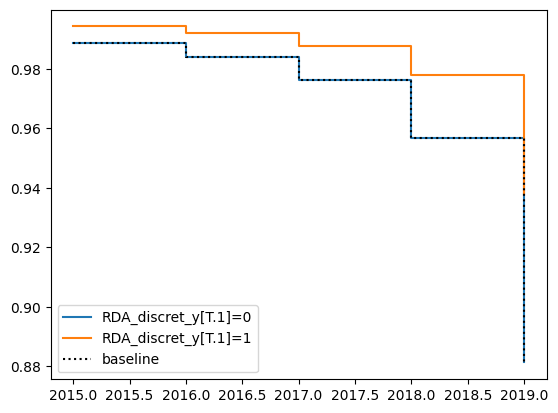

In [537]:
# Choisissez une variable à analyser
covariate = 'RDA_discret_y[T.1]'

# Définissez les valeurs pour lesquelles vous voulez voir l'effet
values = [0, 1]

# Utilisez la fonction plot_partial_effects_on_outcome pour visualiser l'effet
cph_model.plot_partial_effects_on_outcome(covariates=covariate, values=values)


In [538]:
test_predictions = cph_model.predict_expectation(X_test)

In [539]:
# Add the predicted survival times to the test set
test_set_with_predictions = test_set.assign(predicted_survival=test_predictions.values)

# Sort the individuals by predicted survival time
sorted_test_set = test_set_with_predictions.sort_values(by='predicted_survival')

sorted_test_set.head(10)


,numtiers,defaut_y,Annee_y,Secteur_Classe_y,RE_discret_y,RDA_discret_y,MBE_discret_y,RD_discret_y,IMPACT_SOCIAUX_ENVIRONNEMENTAL_y,Censure,predicted_survival
373,5200001298883,0,2019,Infrastructure et Finance,0,0,0,1,"Aucun impact social ou environnemental, soumis...",1,3.392207
393,5200001298951,1,2015,Infrastructure et Finance,0,0,0,1,"Aucun impact social ou environnemental, soumis...",0,3.392207
1234,5200007213395,0,2018,Infrastructure et Finance,0,0,0,1,"Aucun impact social ou environnemental, soumis...",1,3.392207
398,5200001298962,0,2018,Infrastructure et Finance,0,0,0,1,"Aucun impact social ou environnemental, soumis...",1,3.392207
1374,5200008000880,0,2018,Infrastructure et Finance,0,1,0,1,"Aucun impact social ou environnemental, soumis...",1,3.668848
1377,5200008000880,0,2017,Infrastructure et Finance,0,1,0,1,"Aucun impact social ou environnemental, soumis...",1,3.668848
321,5200001149909,0,2017,Infrastructure et Finance,0,1,0,1,"Aucun impact social ou environnemental, soumis...",1,3.668848
1405,5200008164815,0,2016,Infrastructure et Finance,0,1,0,1,"Aucun impact social ou environnemental, soumis...",1,3.668848
1275,5200007349840,0,2015,Infrastructure et Finance,0,0,1,1,"Aucun impact social ou environnemental, soumis...",1,3.672356
361,5200001298810,0,2016,Infrastructure et Finance,0,0,1,1,"Aucun impact social ou environnemental, soumis...",1,3.672356


##### $\textbf{Exemples}$

In [540]:
#pour cette on a predit que l'entreprise allait avoir un defaut au bout de 3.4 année ce qui semble être coherent si on fait round up
#ce qui rend le resultat un peu biaisé c'est ce que ses covariable ont changé au cours du temps d'observation
ex1 = jr[jr['numtiers'] == 5200007630651]

# Afficher le résultat
ex1[['numtiers','Annee','defaut']]

,numtiers,Annee,defaut
837,5200007630651,2015,0
838,5200007630651,2016,0
839,5200007630651,2017,0
840,5200007630651,2018,0
1313,5200007630651,2019,0


### $\textbf{Allons un peu plus loin avec d'autres modèle de prédiction}$

Même si notre modèle semble avoir un bon score de Concordance ceci ne fait pas l'unamité si l'on observe les indivdu en défaut. Certes, il arrive à prédire des temps de survie convenable mais la base étant imbalancé il faut toujours porter attention à cet aspect.

Malgré que les modèles de Survie sont assez robustes aux bases imbalancé on va tester d'autres méthodes avec réechantillonage pour voir les performances. 

In [541]:
jr2 = jr.copy()
jr2 = jr2[['defaut', 'Secteur_Classe', 'RE_discret', 'RDA_discret', 'MBE_discret', 'RD_discret' , 'IMPACT_SOCIAUX_ENVIRONNEMENTAL']]
# Encodage des variables catégorielles
le = LabelEncoder()
for col in jr2.columns[jr2.dtypes == "object"]:
    jr2[col] = le.fit_transform(jr2[col])

# Séparation des données en ensembles d'entraînement et de test
X = jr2.drop('defaut', axis=1)
y = jr2['defaut']

# Application de SMOTE
smote = SMOTE(random_state=2200014)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled_smote, y_resampled_smote, test_size=0.2, random_state=2200014)

##### $\textbf{Modèle 1 : Random Forest}$

In [542]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
# Prédiction sur l'ensemble de test
y_pred = rf_model.predict(X_test)

# Affichage du rapport de classification
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81       294
           1       0.80      0.84      0.82       294

    accuracy                           0.81       588
   macro avg       0.81      0.81      0.81       588
weighted avg       0.81      0.81      0.81       588



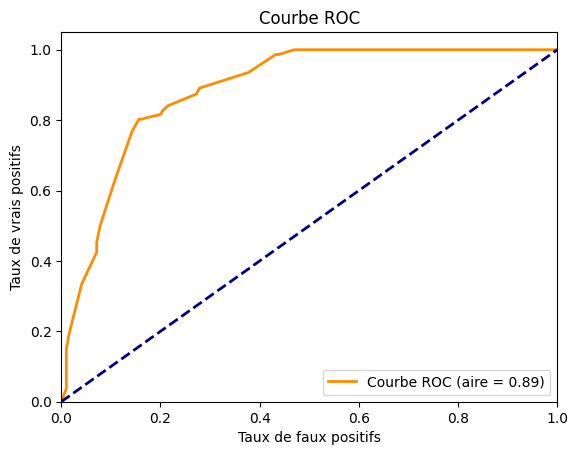

In [543]:
# Prédiction des probabilités de la classe positive
y_pred_proba = rf_model.predict_proba(X_test)[::,1]

# Calcul de la courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Calcul de l'aire sous la courbe ROC
roc_auc = auc(fpr, tpr)

# Tracé de la courbe ROC
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Courbe ROC (aire = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

#### $\textbf{Modèle 2 : Régression Logistique}$

In [544]:
lg_model = LogisticRegression()
lg_model.fit(X_train, y_train)
y_pred_lg = lg_model.predict(X_test)
print(classification_report(y_test, y_pred_lg))

              precision    recall  f1-score   support

           0       0.80      0.64      0.71       294
           1       0.70      0.84      0.77       294

    accuracy                           0.74       588
   macro avg       0.75      0.74      0.74       588
weighted avg       0.75      0.74      0.74       588



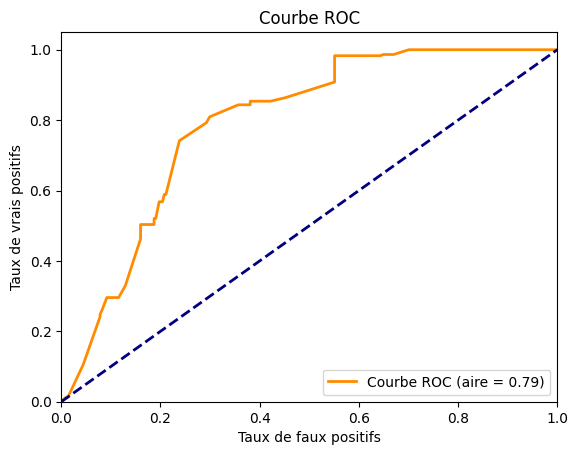

In [545]:
# Prédiction des probabilités de la classe positive
y_pred_proba_lg = lg_model.predict_proba(X_test)[::,1]

# Calcul de la courbe ROC
fpr_lg, tpr_lg, _ = roc_curve(y_test, y_pred_proba_lg)

# Calcul de l'aire sous la courbe ROC
roc_auc_lg = auc(fpr_lg, tpr_lg)

# Tracé de la courbe ROC
plt.figure()
lw = 2
plt.plot(fpr_lg, tpr_lg, color='darkorange', lw=lw, label='Courbe ROC (aire = %0.2f)' % roc_auc_lg)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()


#### $\textbf{Modèle 3 : Arbre de Décision}$

In [546]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81       294
           1       0.80      0.84      0.82       294

    accuracy                           0.81       588
   macro avg       0.81      0.81      0.81       588
weighted avg       0.81      0.81      0.81       588



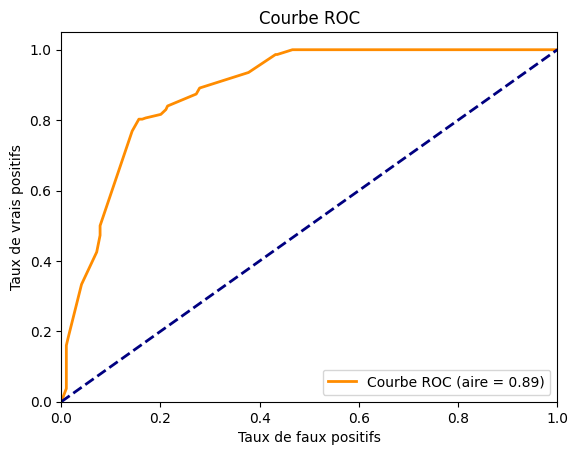

In [547]:
# Prédiction des probabilités de la classe positive
y_pred_proba_dt = dt_model.predict_proba(X_test)[::,1]

# Calcul de la courbe ROC
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)

# Calcul de l'aire sous la courbe ROC
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Tracé de la courbe ROC
plt.figure()
lw = 2
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=lw, label='Courbe ROC (aire = %0.2f)' % roc_auc_dt)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.80      0.64      0.71       294
           1       0.70      0.84      0.77       294

    accuracy                           0.74       588
   macro avg       0.75      0.74      0.74       588
weighted avg       0.75      0.74      0.74       588

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       294
           1       0.80      0.84      0.82       294

    accuracy                           0.81       588
   macro avg       0.81      0.81      0.81       588
weighted avg       0.81      0.81      0.81       588

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       294
           1       0.80      0.84      0.82       294

    accuracy                           0.81       588

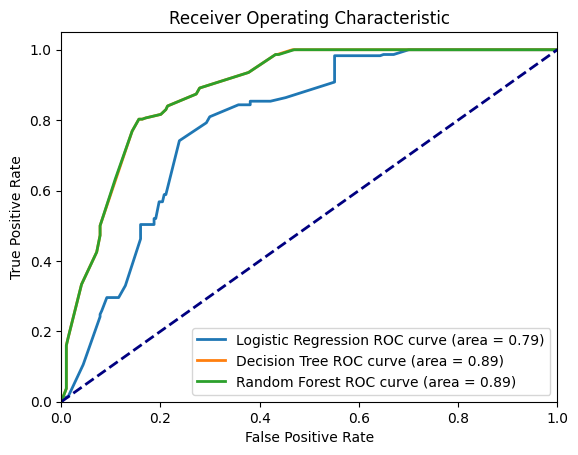

In [548]:
# Définition des modèles
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
}

plt.figure()

# Boucle sur les modèles
for name, model in models.items():
    # Entraînement du modèle
    model.fit(X_train, y_train)
    
    # Prédiction des probabilités de la classe positive
    y_pred_proba = model.predict_proba(X_test)[::,1]
    
    # Calcul de la courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    
    # Calcul de l'aire sous la courbe ROC
    roc_auc = auc(fpr, tpr)
    
    # Tracé de la courbe ROC
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='%s ROC curve (area = %0.2f)' % (name, roc_auc))
    
    # Prédiction sur l'ensemble de test
    y_pred = model.predict(X_test)
    
    # Affichage du rapport de classification
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))

# Tracé de la ligne diagonale
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


#### $\textbf{Conclusion}$

On remarque dans notre cas qu'après réechantillonage le modèle de Forêt Aléatoire et Arbre de décision fournissent un resultat plus évident que le modèle de Régression logistique. 

A noter qu'on a utilisé les mêmes variables explicatives pour se raméner à une comparaison plus simple des modèles.

A croire l'AUC les deux modèles : $\textbf{DecisionTree et RandomForest}$ sont les mieux pour prédire le défaut.